# **Covid19 Text-Classification - NLP Bert - TensorFlow**

references:
- Huggingface Bert model: https://huggingface.co/bert-base-uncased
- https://www.tensorflow.org/tutorials/text/classify_text_with_bert
- https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer


In [1]:
# pip install tensorflow-text (preprocessing for BERT inputs)
# pip install -q tf-models-official
# pip install --upgrade tensorflow_hub

In [2]:
pip install tensorflow-text

     |████████████████████████████████| 3.4 MB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -q tf-models-official

Note: you may need to restart the kernel to use updated packages.


In [4]:
# -- Import Libraries -- 
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from official.nlp import optimization
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers, losses, preprocessing

tf.get_logger().setLevel('ERROR')

In [5]:
# -- Global Variables -- 
TRAIN_PATH = '../input/covid-19-nlp-text-classification/Corona_NLP_train.csv'  
TEST_PATH = '../input/covid-19-nlp-text-classification/Corona_NLP_test.csv' 
CLASSES = ['Extremely Negative', 'Negative', 'Positive', 'Extremely Positive', 'Neutral']
BATCH_SIZE = 128
EPOCHS = 16
LEARNING_RATE = 1e-05 #small gradient steps to prevent forgetting in transfer learning.

# MODEL_NAME = 'bert-base-uncased'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [6]:
# -- Load Data -- 
train_data = pd.read_csv(TRAIN_PATH, encoding='L1')
test_data = pd.read_csv(TEST_PATH,encoding='L1')

train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


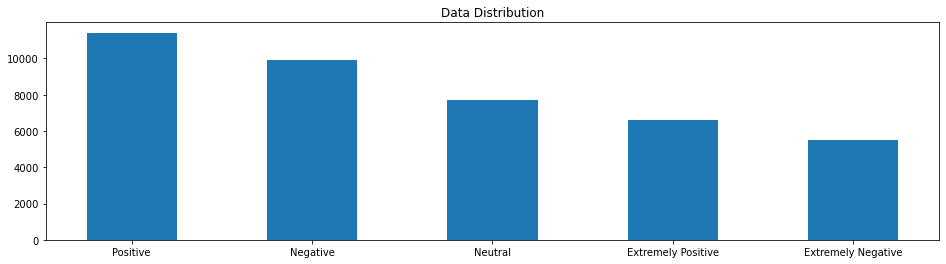

In [7]:
# -- Data distribution -- 
fig = plt.figure(figsize=(16, 4))

x=train_data.Sentiment.value_counts()

plt.bar(x=x.index,
        height=x.values,
        width=0.5)

plt.title('Data Distribution')

plt.show()

In [8]:
# -- Pre-processing -- 

# drop empty tweets, and unclassified tweets.
train_data.OriginalTweet.dropna()
train_data.Sentiment.dropna()
test_data.OriginalTweet.dropna()
test_data.Sentiment.dropna()

# remove stop-words
sw_nltk = stopwords.words('english')
func = lambda text : " ".join([word for word in str(text).split() if word.lower() not in sw_nltk])
train_data['OriginalTweet'] = train_data['OriginalTweet'].apply(func)

# TODO: remove Urls and HTML links

In [9]:
# -- Split Data to train, validation and test -- 
train_X, val_X, train_y, val_y = model_selection.train_test_split(train_data['OriginalTweet'],
                                                                  train_data['Sentiment'], 
                                                                  test_size=0.3)

test_X, test_y = test_data['OriginalTweet'],test_data['Sentiment']

In [10]:
# -- convert labels to one hot --
label_encoder = LabelEncoder()

vec = label_encoder.fit_transform(train_y)
train_y = tf.keras.utils.to_categorical(vec)

vec = label_encoder.fit_transform(val_y)
val_y = tf.keras.utils.to_categorical(vec)

vec = label_encoder.fit_transform(test_y)
test_y = tf.keras.utils.to_categorical(vec)

In [11]:
# -- Creating the Model for Fine Tuning -- 
def bert_text_classification():

    # - text input -
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        
    # - preprocessing layer - 
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        
    # - encoding - 
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        
    # - output -
    outputs = encoder(encoder_inputs)
        
    # - classifier layer -
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    
    model = tf.keras.Model(text_input, net)
    return model
        
model = bert_text_classification()     

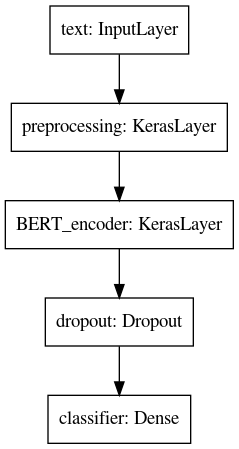

In [12]:
# running the model on some random text, of course that doesn't mean anything, since we haven't trained the model yet, 
# it just so we will be able to print the model structure 
test_text = ['some random tweet']
bert_raw_result = model(tf.constant(test_text))

# -- Model structure -- 
tf.keras.utils.plot_model(model)

In [13]:
# -- Loss -- 
loss = tf.keras.losses.CategoricalCrossentropy()

# -- Optimizer -- 
# will use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). 
train_data_size = len(train_X)
steps_per_epoch = int(train_data_size/BATCH_SIZE)
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps/BATCH_SIZE)

optimizer = optimization.create_optimizer(init_lr=LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# -- compile the model --
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [14]:
# -- Fine Tuning the Model --
history = model.fit(x=train_X,
                    y=train_y,
                    validation_data=(val_X, val_y),
                    epochs=EPOCHS,
                    validation_steps=1,
                    verbose=1,
                    batch_size=BATCH_SIZE)

Epoch 1/16
226/226 [==============================] - 233s 1s/step - loss: 1.6202 - accuracy: 0.2833 - val_loss: 1.1399 - val_accuracy: 0.4844
Epoch 2/16
226/226 [==============================] - 227s 1s/step - loss: 1.1954 - accuracy: 0.4862 - val_loss: 0.9694 - val_accuracy: 0.6016
Epoch 3/16
226/226 [==============================] - 226s 1000ms/step - loss: 1.0139 - accuracy: 0.5791 - val_loss: 0.8858 - val_accuracy: 0.6328
Epoch 4/16
226/226 [==============================] - 226s 1000ms/step - loss: 0.9176 - accuracy: 0.6274 - val_loss: 0.8149 - val_accuracy: 0.7031
Epoch 5/16
226/226 [==============================] - 226s 1000ms/step - loss: 0.8572 - accuracy: 0.6618 - val_loss: 0.7616 - val_accuracy: 0.7500
Epoch 6/16
226/226 [==============================] - 226s 999ms/step - loss: 0.8068 - accuracy: 0.6841 - val_loss: 0.7610 - val_accuracy: 0.7422
Epoch 7/16
226/226 [==============================] - 227s 1s/step - loss: 0.7691 - accuracy: 0.7016 - val_loss: 0.7875 - val_a

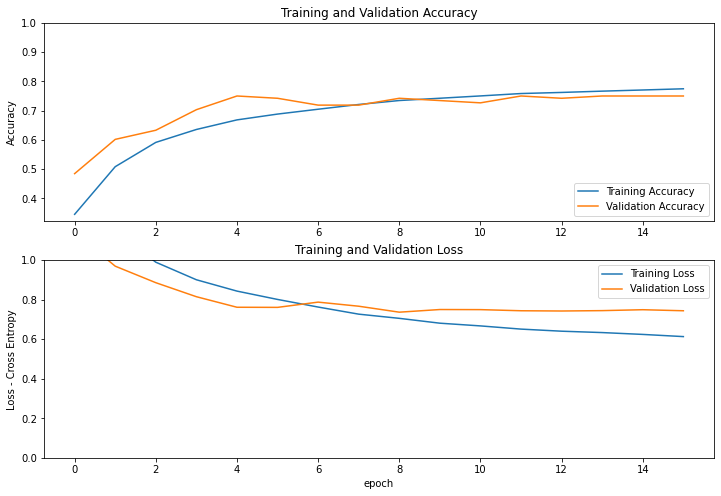

In [15]:
# -- Plot training and validation loss and accuracy --
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
    
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
    
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss - Cross Entropy')
plt.xlabel('epoch')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
    
plt.show()

In [16]:
# -- Testing --
loss, acc = model.evaluate(x=test_X,
                           y=test_y)
print("test loss: ", loss, ", test acc: ", 100*acc, "%")

119/119 [==============================] - 11s 95ms/step - loss: 0.7686 - accuracy: 0.7054
test loss:  0.768588125705719 , test acc:  70.53712606430054 %


In [17]:
# -- Save the Model -- 
model.save('classifier_model')

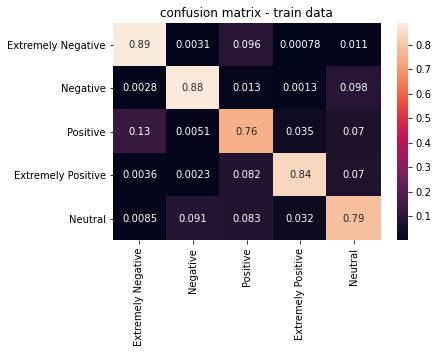

In [18]:
# -- Confusion matrix -- 
plt.title('confusion matrix - train data')
plt.xlabel("Predicted")
plt.ylabel("True")

preds = model.predict(train_X)

# Convert the one-hot vectors to labels
train_y_labels = tf.argmax(train_y, axis = 1)
preds_labels = tf.argmax(preds, axis = 1)

cm_train = tf.math.confusion_matrix(train_y_labels,
                                    preds_labels,5,
                                    dtype=tf.dtypes.float32)

# Normalize the confusion matrix so that each row sums to 1.
cm_train = cm_train/cm_train.numpy().sum(axis=1)[:, tf.newaxis]

sns.heatmap(data=cm_train,
            annot=True,
            xticklabels=CLASSES,
            yticklabels=CLASSES)

plt.show()